In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34437")
client

<Client: 'tcp://127.0.0.1:34437' processes=6 threads=6, memory=75.38 GiB>

In [2]:
import numpy as np
import xarray as xr
import dask.array as dsar
import os.path as op
import qgutils
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
ddir = '/bettik/uchidat/qg-ensemble/runs/seas-forcing/10percent/'
sdir = '/bettik/uchidat/qg-ML/'

In [4]:
U = .1
T = 5e5      # seconds
L     = U*T
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 256*4    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 187

percent = 10
nmemb = 100

In [5]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd < 4:
        psi = qgutils.pad_bc(psi)
    elif nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def laplacian(psi, Delta=1, bc='dirichlet', padded=False, 
              dim=['Z','Yp1','Xp1'], chunks={'Yp1':100,'Xp1':100}
             ):
    
    nd = psi.ndim
    if padded:
        psi_padded = psi
    else:
        if nd == 3:
            psi_padded = xr.DataArray(qgutils.pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)
        else:
            psi_padded = xr.DataArray(pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)
    
#     lap = (psi_padded[...,2:,1:-1] + psi_padded[...,:-2,1:-1] 
#            + psi_padded[...,1:-1,2:] + psi_padded[...,1:-1,:-2] 
#            - 4*psi_padded[...,1:-1,1:-1]
#           ) / Delta**2

    lap = (psi_padded.isel(Yp1=slice(2,None),Xp1=slice(1,-1)).data 
           + psi_padded.isel(Yp1=slice(None,-2),Xp1=slice(1,-1)).data
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(2,None)).data 
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(None,-2)).data
           - 4*psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
          ) / Delta**2

    return xr.DataArray(lap, dims=psi_padded.dims, 
                        coords=psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coords
                       )

In [6]:
dsp = xr.open_zarr(op.join(ddir, "Eddy-Z0_%010d.zarr" % 0))
psip = xr.DataArray(pad_bc(dsp.p.data), 
                    dims=['nmemb','Yp1','Xp1'],
                    coords={'nmemb':range(101),
                            'Yp1':np.arange(-dx/2,L0+dx,dx),
                            'Xp1':np.arange(-dx/2,L0+dx,dx)}
                   )

up = -psip.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
vp = psip.isel(Yp1=slice(1,-1)).diff('Xp1') / dx

In [8]:
EKE = .25*xr.DataArray((up**2).isel(Yp1=slice(None,-1)).data 
                        + (up**2).isel(Yp1=slice(1,None)).data 
                        + (vp**2).isel(Xp1=slice(None,-1)).data 
                        + (vp**2).isel(Xp1=slice(1,None)).data,
                       dims=['nmemb','YC','XC'], 
                       coords={'nmemb':dsp.nmemb.data,
                               'YC':dsp.YC.data,'XC':dsp.XC.data}
                      ).mean('nmemb').compute()

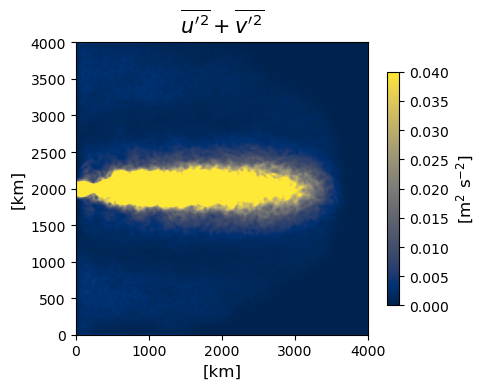

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
fig.set_tight_layout(True)

im = ax.pcolormesh(dsp.XC*L*1e-3, dsp.YC*L*1e-3, EKE*U**2,
                   vmin=0, vmax=.04, cmap='cividis', rasterized=True)

ax.set_aspect(1)

ax.set_title(r"$\overline{u'^2} + \overline{v'^2}$", fontsize=15)

ax.set_xlabel(r"[km]", fontsize=12)
ax.set_ylabel(r"[km]", fontsize=12)

cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)

plt.savefig(op.join(sdir,'Figs/QG-EKE.pdf'))

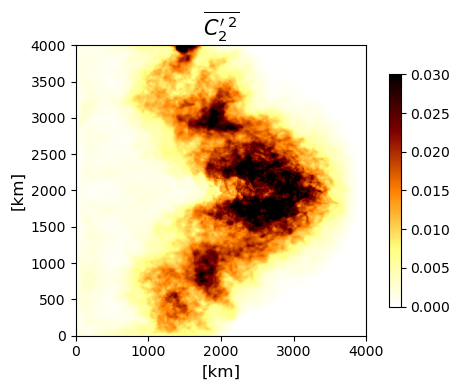

In [17]:
fig, ax = plt.subplots(figsize=(5,4))
fig.set_tight_layout(True)

im = ax.pcolormesh(dsp.XC*L*1e-3, dsp.YC*L*1e-3, (dsp.ptr2**2).mean('nmemb'),
                   vmin=0, vmax=.03, cmap='afmhot_r', rasterized=True)

ax.set_aspect(1)

ax.set_title(r"$\overline{C_2'^2}$", fontsize=15)

ax.set_xlabel(r"[km]", fontsize=12)
ax.set_ylabel(r"[km]", fontsize=12)

cbar = fig.colorbar(im, ax=ax, shrink=.8)

plt.savefig(op.join(sdir,'Figs/QG-varC2.pdf'))